## Load and Create Dataset

In [1]:
pip install google-cloud-bigquery


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:


# Setup Google Cloud BigQuery API

# Replace with your own key path
key_path = "/Users/theodoreleeiv/Documents/Documents - Theodore’s MacBook Pro/Google Cloud/inbound-density-428819-p8-aef577a5f38e.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

client = bigquery.Client()


def QUERY(query):
    """
    Queries BigQuery
    :param query: string
    :return: dataframe
    """
    query = str(query)
    query_job = client.query(query)
    return query_job.result().to_dataframe()

In [39]:

df = QUERY("""
  SELECT
    r.subject_id,
    r.stay_id,
    r.hadm_id,
    r.readmit_stay_id,
    edadmitdate,
    eddischargedate,
    EXTRACT(DAYOFWEEK FROM edadmitdate) AS admit_dow,
    EXTRACT(MONTH FROM edadmitdate) AS admit_month,
    EXTRACT(YEAR FROM edadmitdate) AS admit_year,
    EXTRACT(DAYOFWEEK FROM eddischargedate) AS discharge_dow,
    EXTRACT(MONTH FROM eddischargedate) AS discharge_month,
    EXTRACT(YEAR FROM eddischargedate) AS discharge_year,
    edadmithour,
    eddischargehour,
    LOS_hr,
    arrival_transport,
    disposition,
    gender,
    anchor_age,
    insurance,
    marital_status,
    language,
    age_group,
    race,
    race_group,
    temperature,
    heartrate,
    resprate,
    o2sat,
    sbp,
    dbp,
    acuity,
    m.name AS med_name,
    icd_title,
    mental_health_category,
    is_readmission
  

FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
  
LEFT JOIN
    `physionet-data.mimiciv_ed.triage` AS t
ON 
    r.stay_id = t.stay_id
LEFT JOIN 
    `physionet-data.mimiciv_ed.medrecon` AS m
ON  
    r.stay_id = m.stay_id
  
WHERE d.is_mh_disorder = 1
""")

In [40]:
# Calculate the number of comorbities per patient per visit

comorbities = QUERY("""
  SELECT
    subject_id,
    stay_id,
    SUM(num_comorbities) AS num_comorbitites
    FROM
    (SELECT
      d.subject_id,
      d.stay_id,
      CASE
        WHEN seq_num > 1 THEN 1
        ELSE 0
      END AS num_comorbities
    FROM
      `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

    WHERE d.is_mh_disorder = 1
    ORDER BY
      num_comorbities DESC) AS patient_counts
GROUP BY
  subject_id,stay_id

""")

In [41]:
# merge the number of comorbitites with the main dataframe on subject_id and stay_id
df = df.merge(comorbities,how='left',on=['subject_id','stay_id'])

### Drop Duplicates

In [42]:
# Drop any duplicates if there are any in the data
df.drop_duplicates(inplace=True)

### Split the Data into training and test sets

In [43]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.25,random_state=42,)

In [19]:
train_df.head()

,subject_id,stay_id,hadm_id,readmit_stay_id,edadmitdate,eddischargedate,admit_dow,admit_month,admit_year,discharge_dow,...,heartrate,resprate,o2sat,sbp,dbp,acuity,med_name,icd_title,mental_health_category,is_readmission
282442,13586936,36539763,22114434,<NA>,2128-06-20,2128-06-20,1,6,2128,1,...,70.000000000,22.000000000,96.000000000,81.000000000,52.000000000,1.000000000,Levetiracetam,SENILE DEMENTIA UNCOMP,Organic Mental Health Disorders,0
246855,12053621,33646898,23701765,33646898,2129-07-31,2129-07-31,1,7,2129,1,...,68.000000000,16.000000000,100.000000000,108.000000000,70.000000000,3.000000000,None,ALCOHOL ABUSE-UNSPEC,Substance-Related Mental Disorders,1
408170,13803192,38348066,24898687,<NA>,2178-09-08,2178-09-09,3,9,2178,4,...,None,None,None,None,None,None,*e-mycin,"Major depressive disorder, single episode, uns...",Mood Disorders,0
375743,15970768,30068368,29929517,<NA>,2187-08-27,2187-08-27,2,8,2187,2,...,76.000000000,18.000000000,99.000000000,143.000000000,76.000000000,2.000000000,metoprolol tartrate,"DEMENTIA, UNSPECIFIED, WITHOUT BEHAVIORAL DIST...",Organic Mental Health Disorders,0
130680,10199379,38089639,<NA>,<NA>,2161-04-10,2161-04-10,6,4,2161,6,...,80.000000000,20.000000000,100.000000000,133.000000000,93.000000000,2.000000000,lorazepam,DEPRESSIVE DISORDER,Mood Disorders,0


In [20]:
train_df.shape

(215529, 36)

### Check for NaNs

In [21]:
train_df.isnull().sum()

subject_id                     0
stay_id                        0
hadm_id                    66930
readmit_stay_id           148287
edadmitdate                    0
eddischargedate                0
admit_dow                      0
admit_month                    0
admit_year                     0
discharge_dow                  0
discharge_month                0
discharge_year                 0
edadmithour                    0
eddischargehour                0
LOS_hr                         0
arrival_transport              0
disposition                    0
gender                         0
anchor_age                    11
insurance                  22516
marital_status             13063
language                   10505
age_group                      0
race                           0
race_group                     0
temperature                 8132
heartrate                   5173
resprate                    7302
o2sat                       6641
sbp                         5513
dbp       

There is quite of bit of NaNs in the data. However, some NaNs are expected in hadm_id, not all patients have an associated hadm_id or readmit_stay_id, days_to_readmission, med_name (medication name).

In [22]:
train_df.isnull().sum()

subject_id                     0
stay_id                        0
hadm_id                    66930
readmit_stay_id           148287
edadmitdate                    0
eddischargedate                0
admit_dow                      0
admit_month                    0
admit_year                     0
discharge_dow                  0
discharge_month                0
discharge_year                 0
edadmithour                    0
eddischargehour                0
LOS_hr                         0
arrival_transport              0
disposition                    0
gender                         0
anchor_age                    11
insurance                  22516
marital_status             13063
language                   10505
age_group                      0
race                           0
race_group                     0
temperature                 8132
heartrate                   5173
resprate                    7302
o2sat                       6641
sbp                         5513
dbp       

### Clean and Transform Columns

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215529 entries, 282442 to 184474
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   subject_id              215529 non-null  Int64 
 1   stay_id                 215529 non-null  Int64 
 2   hadm_id                 148599 non-null  Int64 
 3   readmit_stay_id         67242 non-null   Int64 
 4   edadmitdate             215529 non-null  dbdate
 5   eddischargedate         215529 non-null  dbdate
 6   admit_dow               215529 non-null  Int64 
 7   admit_month             215529 non-null  Int64 
 8   admit_year              215529 non-null  Int64 
 9   discharge_dow           215529 non-null  Int64 
 10  discharge_month         215529 non-null  Int64 
 11  discharge_year          215529 non-null  Int64 
 12  edadmithour             215529 non-null  Int64 
 13  eddischargehour         215529 non-null  Int64 
 14  LOS_hr                  215529 non-n

Cleaning/Transformation Tasks
- Convert gender column to numeric binary
- Change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, pain, and acuity to float values
- Unmarried individuals, feature engineer a binary variable, married vs unmarried
- Black/African Patiants, feature engineer a binary variable, Black/African?
- PORTUGUESE Patiants, feature engineer a binary variable, PORTUGUESE?
- Cuban Patiants, feature engineer a binary variable, Cuban?
- BLACK/AFRICAN AMERICAN patiants, feature engineer a binary variable, BLACK/AFRICAN AMERICAN?
- Puerto Rican Patiants, feature engineer a binary variable, Puerto Rican?
- Unknown Patiants, feature engineer a binary variable, Unknown?
- Hispanic or Latino Patiants, feature engineer a binary variable, Hispanic or Latino?
- Honduran Patiants, feature engineer a binary variable, Honduran?
- Patients 50 - 59
- Patients 40 - 49
- Num of Comorbitites
- Various medications (Create medication frequiences accounting for medications not listed by setting the default to 0) -> compute frequencies on the training set to prevent data leakage

In [24]:
# Create a customtransofrmer for each column transformation for the pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Change gender column to a binary

class GenderMapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.gender_map = {'F': 0, 'M': 1}  

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Apply the gender mapping to the gender column
        if 'gender' in X_copy.columns:
            X_copy['gender'] = X_copy['gender'].map(self.gender_map)
        return X_copy

In [25]:
# change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, pain, and acuity to float values
class ConvertVitalSignsToFloats(BaseEstimator, TransformerMixin):
    """
    Converts Vital Signs to Floats
    """
    def __init__(self):
        self.type = float
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        X_copy = X.copy()
        
        vital_cols = ['temperature','heartrate','resprate','o2sat','sbp','dbp','acuity']
        
        for col in vital_cols:
            if col in X_copy.columns:
                try:
                    X_copy[col] =  X_copy[col].astype(float)
                except ValueError as e:
                    print(f"[Error] Could not convert column '{col}' to float. Error: {e} converting to NaN")
                    pd.to_numeric(X_copy[col], errors='coerce')
                    
            else:
                print(f'Not Column {col} not found in list')
        return X_copy
    
class CelsiusToFahrenheit(BaseEstimator, TransformerMixin):
    """
    Converts temperature signs recorded in celsisus to fahrenheit
    """
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        X_copy = X.copy()
        
        if 'temperature' in X_copy.columns:
            try:
                 # Create a mask for likely Celsius values
                mask = X_copy['temperature'] <= 38
                X_copy.loc[mask, 'temperature'] = X_copy.loc[mask, 'temperature'] * 9/5 + 32
            except ValueError as e:
                print(f"[Error] Could not convert column. Error: {e}")
        return X_copy
    

In [26]:
# Create an unmarried vs married column from marital status column
class MaritalStatusMapper(BaseEstimator, TransformerMixin):
    """
    Converts marital status to a binary variable, married/partnered vs single/ not partnered
    """
    def __init__(self):
        self.is_married_map = {'None':1,'MARRIED':1,'WIDOWED':0,'DIVORCED':0,'SINGLE':0}

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Apply the gender mapping to the gender column
        if 'marital_status' in X_copy.columns:
            X_copy['marital_status'] = X_copy['marital_status'].map(self.is_married_map)
        return X_copy


In [27]:
# Feature engineer a binary variable for these races:
#  - Black/African
#  - American Indian/Alaska Native Patiants
#  - PORTUGUESE
#  - Cuban
#  - BLACK/AFRICAN AMERICAN
#  - Puerto Rican
#  - Unknown
#  - Hispanic or Latino
#  - Honduran

# print(train_df['race'].unique())
# train_df['Black/African'] = (train_df['race'] == 'BLACK/AFRICAN').astype(int)
# train_df['American Indian/Alask Native'] = (train_df['race'] == 'AMERICAN INDIAN/ALASKA NATIVE').astype(int)
# train_df['Portueguese'] = (train_df['race'] == 'PORTUGUESE').astype(int)
# train_df['Cuban'] = (train_df['race'] == 'HISPANIC/LATINO - CUBAN').astype(int)
# train_df['Puerto Rican'] = (train_df['race'] ==  'HISPANIC/LATINO - PUERTO RICAN').astype(int)
# train_df['African American'] = (train_df['race'] ==  'BLACK/AFRICAN AMERICAN').astype(int)
# train_df['Unknown'] = (train_df['race'] ==  'UNKNOWN').astype(int)
# train_df['Puerto Rican'] = (train_df['race'] ==  'HISPANIC/LATINO - PUERTO RICAN').astype(int)
# train_df['Hispanic or Latino'] = (train_df['race'] ==  'HISPANIC OR LATINO').astype(int)
# train_df['Honduran'] = (train_df['race'] == 'HISPANIC/LATINO - HONDURAN').astype(int)

In [28]:
# Feature engineer binary variables for Patients 50 - 59 and Patients 40 - 49
# print(train_df['age_group'].unique())
# train_df['90s'] = (train_df['age_group'] == '90+').astype(int)
# train_df['80s'] = (train_df['age_group'] == '80-89').astype(int)
# train_df['70s'] = (train_df['age_group'] == '70-79').astype(int)
# train_df['60s'] = (train_df['age_group'] == '60-69').astype(int)
# train_df['50s'] = (train_df['age_group'] == '50-59').astype(int)
# train_df['40s'] = (train_df['age_group'] == '40-49').astype(int)
# train_df['30s'] = (train_df['age_group'] == '30-39').astype(int)
# train_df['20s'] = (train_df['age_group'] == '20-29').astype(int)
# train_df['10s'] = (train_df['age_group'] == '10-19').astype(int)

In [30]:
class GetTotalAdmissionsAndDischarges(BaseEstimator, TransformerMixin):
    """
    Calculates total admissions and discharges per admission day and discharge day, respectively
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        
        # calculate the total admissions and total discharges 
        total_admissions = X_copy.groupby(by='edadmitdate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_admissions'})
        total_discharges = X_copy.groupby(by='eddischargedate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_discharges'})
        
        # merge these with original dataframe
        X_copy = X_copy.merge(total_admissions,how='left',on=['edadmitdate'])
        X_copy = X_copy.merge(total_discharges,how='left',on=['eddischargedate'])
        return X_copy


In [68]:
from collections import defaultdict

class GetMedicationFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode medications using their frequency
    """
    def __init__(self):
        self.med_to_freq = None
        self.freq_to_meds = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['med_name'].value_counts().to_dict()
        
        # Mapping: med_names → frequency
        self.med_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of med_names
        self.freq_to_meds = defaultdict(set)
        for med, freq in freqs.items():
            self.freq_to_meds[freq].add(med)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['med_name'] =  X_copy['med_name'].map(self.med_to_freq)
        
        # Rename the med column name
        X_copy.rename(columns={'med_name':'med_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit

        med_freq_id = X_copy.groupby(['stay_id'])['med_freq_id'].sum().reset_index()
        med_freq_id.rename(columns={'med_freq_id':'sum_of_med_freq_id'},inplace=True)
        
        # Drop the old med freq id and drop duplicates
        X_copy.drop(columns=['med_freq_id'],axis=1,inplace=True)
        X_copy.drop_duplicates(inplace=True)
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(med_freq_id,how='left',on=['stay_id'])
        
        return X_copy
    



In [34]:
class GetDisposition(BaseEstimator, TransformerMixin):
    """
    Creates a binary variable to indiciate whether a patient LWBS or was treated prior to leaving the facility
    """
    def __init__(self):
        self.dispositions = ['ELOPED','LEFT AGAINST MEDICAL ADVICE','LEFT WITHOUT BEING SEEN']

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # 1 if the patient left without getting proper treatment else 0
        X_copy['disposition'].apply(lambda x: 1 if x in self.dispositions else 0 )
        return X_copy

In [76]:
class GetDiagnosesFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode Patient Diagnoses and creates a summed value
    """
    def __init__(self):
        self.diagnosis_to_freq = None
        self.freq_to_diangosis = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['icd_title'].value_counts().to_dict()
        
        # Mapping: med_names → frequency
        self.diagnosis_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of med_names
        self.freq_to_diangosis = defaultdict(set)
        for med, freq in freqs.items():
            self.freq_to_diangosis[freq].add(med)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['icd_title'] =  X_copy['icd_title'].map(self.diagnosis_to_freq)
        
        # Rename the icd title column name
        X_copy.rename(columns={'icd_title':'icd_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit
        icd_freq_id = X_copy.groupby(['stay_id'])['icd_freq_id'].sum().reset_index()
        icd_freq_id.rename(columns={'icd_freq_id':'sum_of_icd_freq_id'},inplace=True)
        
        # Drop the old diangoses freq id and drop duplicates
        X_copy.drop(columns=['icd_freq_id'],inplace=True)
        X_copy.drop_duplicates(inplace=True)
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(icd_freq_id,how='left',on=['stay_id'])
        
        return X_copy

In [45]:
class NumericImputer(BaseEstimator, TransformerMixin):
    """
    Only imputes numeric columns
    """
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.numeric_cols = []

    def fit(self, X, y=None):
        self.numeric_cols = X.select_dtypes(include='number').columns
        self.imputer.fit(X[self.numeric_cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.imputer.transform(X_copy[self.numeric_cols])
        return X_copy

### Create Preprocessing Pipeline

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Build Preprocessing Pipeline for later preprocessing of new data
X_train_preprocessing_Pipeline = Pipeline(
    [
        ('MapGender',GenderMapper()),
        ('ConvertVitalSigns',ConvertVitalSignsToFloats()),
        ('CelsiusToFahrenheit',CelsiusToFahrenheit()),
        ('MaritalStatusMapper',MaritalStatusMapper()),
        ('GetTotalAdmissionsAndDischarges',GetTotalAdmissionsAndDischarges()),
        ('GetMedicationFrequencies',GetMedicationFrequencies()),
        ('GetDisposition',GetDisposition()),
        ('GetDiagnosesFrequencies',GetDiagnosesFrequencies()),
        ('SimpleImputer', NumericImputer(strategy='mean'))  # Fill the nulls with the mean value for applicable features
    ]
)
train_df_cleaned = X_train_preprocessing_Pipeline.fit_transform(df)


### Identify Outliers

In [78]:
train_df_cleaned.describe()

,subject_id,stay_id,hadm_id,readmit_stay_id,admit_dow,admit_month,admit_year,discharge_dow,discharge_month,discharge_year,...,o2sat,sbp,dbp,acuity,is_readmission,num_comorbitites,total_admissions,total_discharges,sum_of_med_freq_id,sum_of_icd_freq_id
count,6.646800e+04,6.646800e+04,6.646800e+04,6.646800e+04,66468.000000,66468.000000,66468.000000,66468.000000,66468.000000,66468.000000,...,66468.000000,66468.000000,66468.000000,66468.000000,66468.000000,66468.000000,66468.000000,66468.000000,66468.000000,66468.000000
mean,1.508661e+07,3.500476e+07,2.501613e+07,3.500313e+07,4.002964,6.582100,2156.258771,4.001535,6.587365,2156.259704,...,98.130167,132.286570,81.911534,2.494417,0.316558,0.585725,21.376708,21.222062,13690.574321,15312.771559
std,2.739044e+06,2.884913e+06,2.331400e+06,1.620158e+06,2.010333,3.463943,24.607747,2.008489,3.463111,24.607960,...,6.428342,19.752206,79.165388,0.603841,0.465137,0.635206,30.073032,29.820510,31315.434932,19850.666324
min,1.000008e+07,3.000002e+07,2.000020e+07,3.000002e+07,1.000000,1.000000,2110.000000,1.000000,1.000000,2110.000000,...,0.000000,1.000000,7.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,1.281614e+07,3.251855e+07,2.383587e+07,3.500313e+07,2.000000,4.000000,2135.000000,2.000000,4.000000,2135.000000,...,97.000000,119.000000,71.000000,2.000000,0.000000,0.000000,4.000000,4.000000,0.000000,2303.000000
50%,1.531183e+07,3.500416e+07,2.501613e+07,3.500313e+07,4.000000,7.000000,2158.000000,4.000000,7.000000,2158.000000,...,98.130167,132.000000,80.000000,2.494417,0.000000,1.000000,11.000000,11.000000,429.000000,9212.000000
75%,1.734883e+07,3.750096e+07,2.620333e+07,3.500313e+07,6.000000,10.000000,2176.000000,6.000000,10.000000,2176.000000,...,100.000000,143.000000,89.000000,3.000000,1.000000,1.000000,26.000000,26.000000,13388.500000,20686.000000
max,1.999947e+07,3.999996e+07,2.999928e+07,3.999996e+07,7.000000,12.000000,2211.000000,7.000000,12.000000,2211.000000,...,1000.000000,776.000000,9110.000000,5.000000,1.000000,5.000000,370.000000,386.000000,483048.000000,168201.000000


- There are outliers in just about every column. So, I'll have to handle these outliers because they mess up correlations

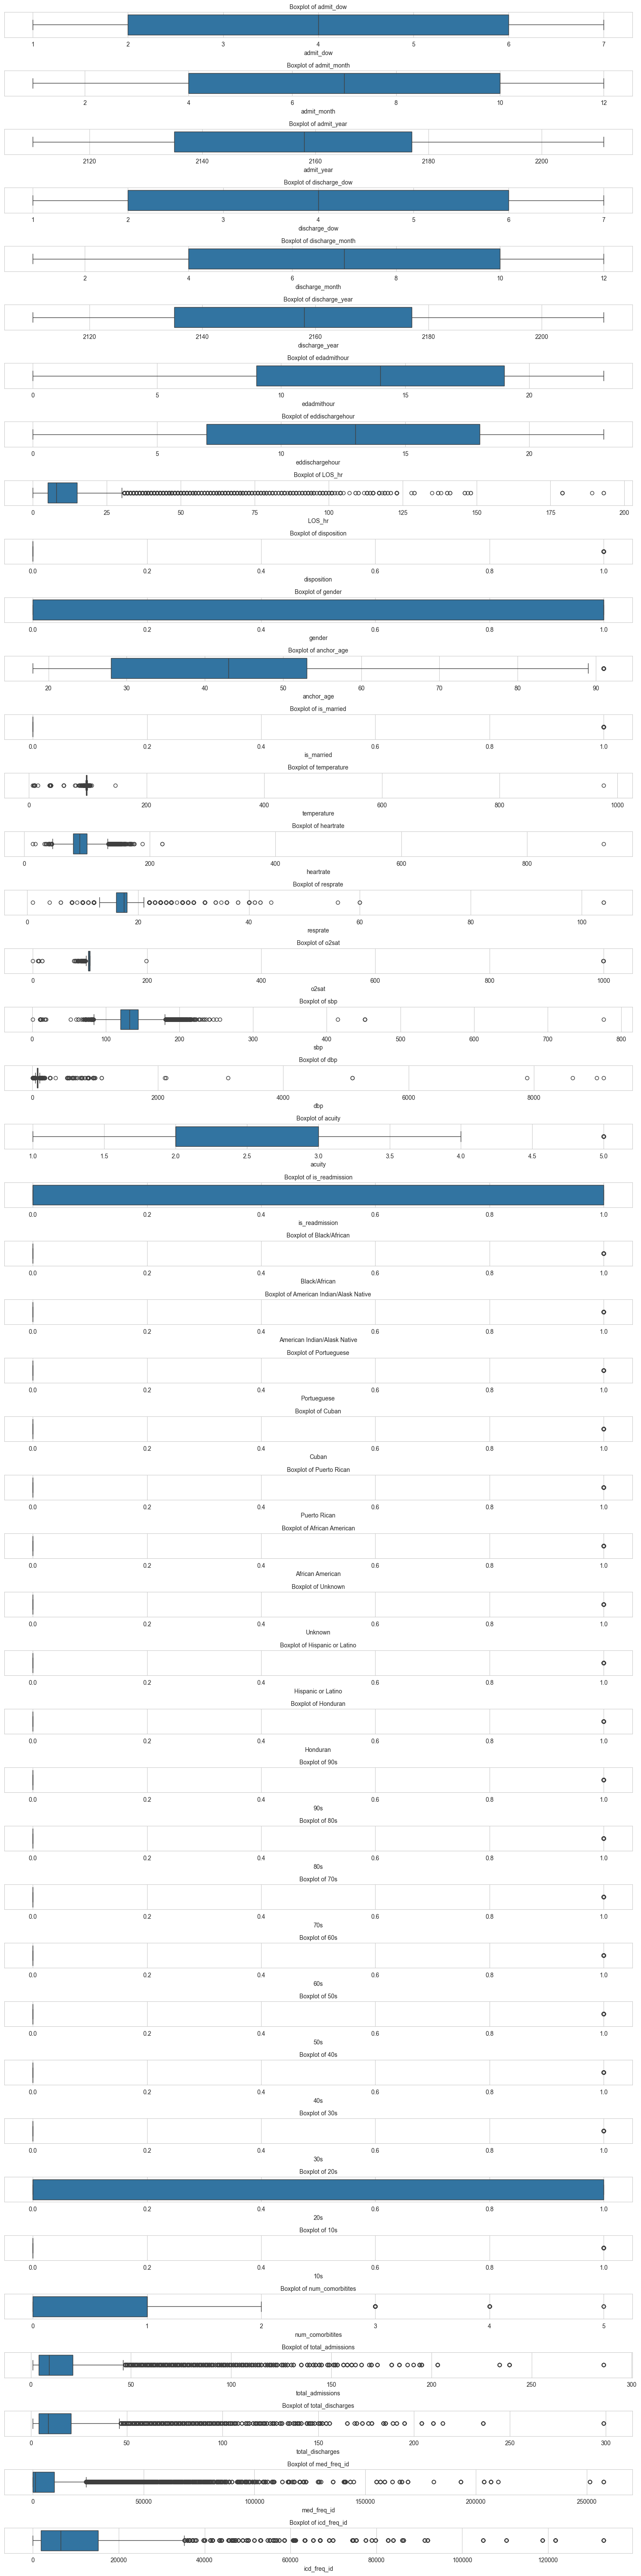

In [117]:
# Create Boxplots to identify Outliers
# Filter numeric columns
numeric_cols = train_df_cleaned.drop(['subject_id','stay_id','hadm_id','readmit_stay_id'],axis=1).select_dtypes(include=['int64', 'Int64', 'float64']).columns

# Set up the plot grid
plt.figure(figsize=(15, 60))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=train_df_cleaned[col])
    plt.title(f'Boxplot of {col}', fontsize=10)
    plt.tight_layout()

plt.show()

In [154]:
train_df_cleaned.columns

Index(['subject_id', 'stay_id', 'hadm_id', 'readmit_stay_id', 'edadmitdate',
       'eddischargedate', 'admit_dow', 'admit_month', 'admit_year',
       'discharge_dow', 'discharge_month', 'discharge_year', 'edadmithour',
       'eddischargehour', 'LOS_hr', 'arrival_transport', 'disposition',
       'gender', 'anchor_age', 'insurance', 'is_married', 'language',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity',
       'mental_health_category', 'is_readmission', 'Black/African',
       'American Indian/Alask Native', 'Portueguese', 'Cuban', 'Puerto Rican',
       'African American', 'Unknown', 'Hispanic or Latino', 'Honduran', '90s',
       '80s', '70s', '60s', '50s', '40s', '30s', '20s', '10s',
       'num_comorbitites', 'total_admissions', 'total_discharges',
       'med_freq_id', 'icd_freq_id'],
      dtype='object')

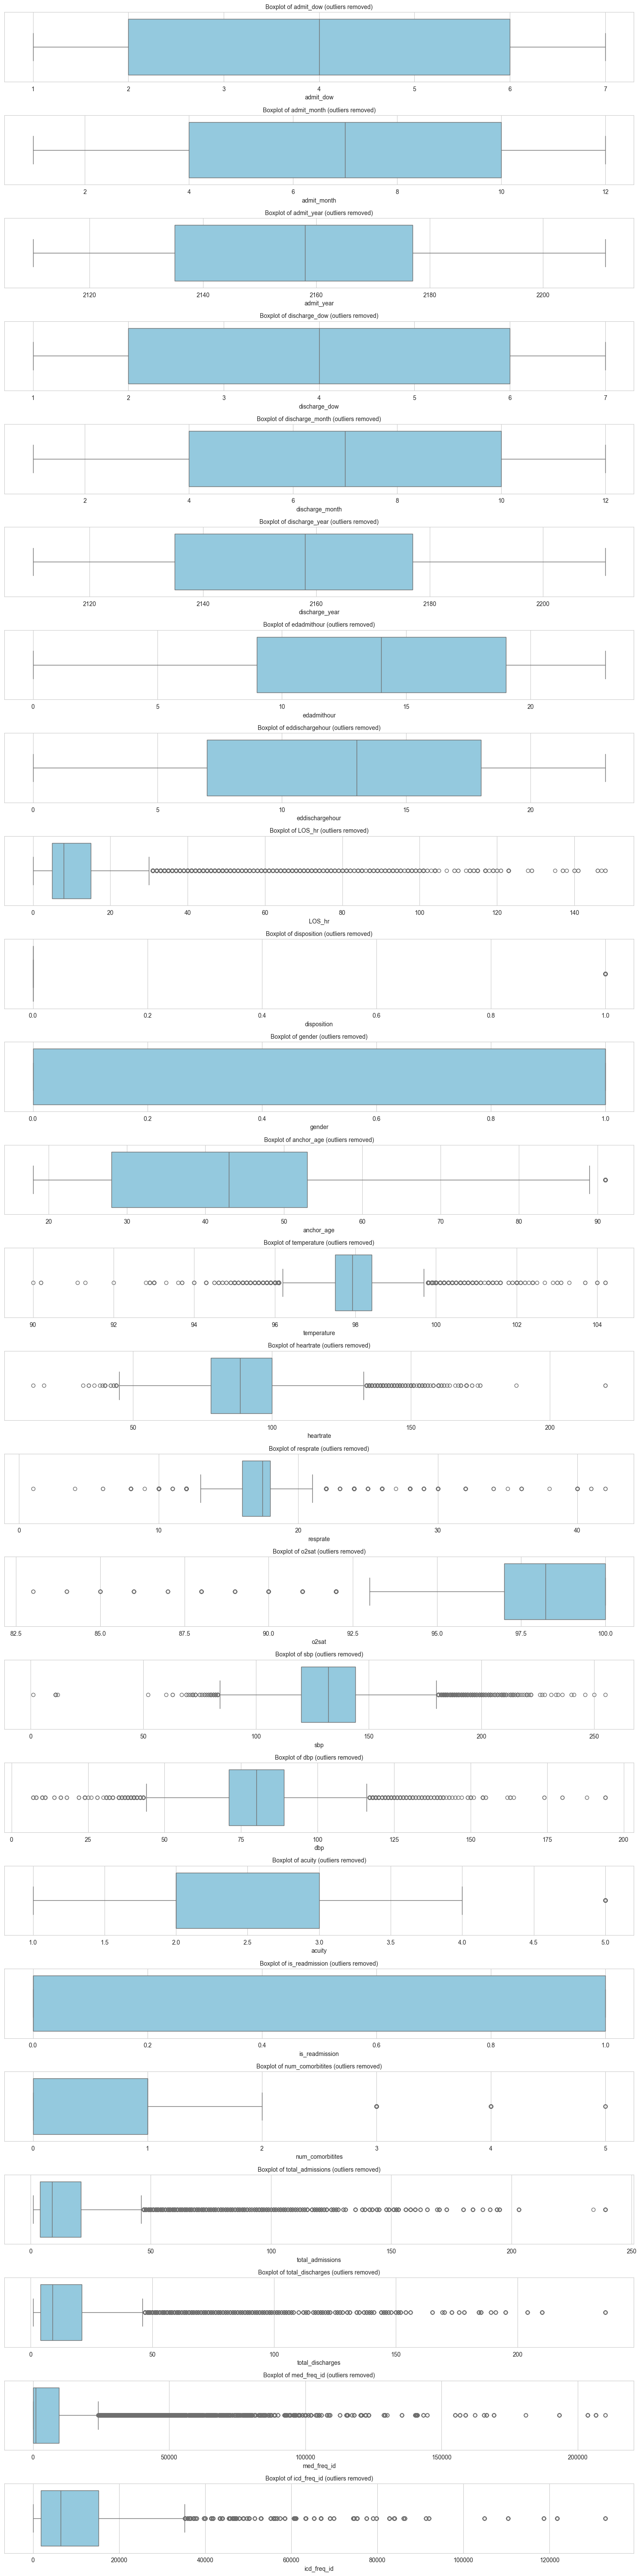

In [155]:
# use basic IQR method to remove outliers
train_df_outliers_removed = train_df_cleaned.copy()

train_df_outliers_removed.drop([
    'is_married','Black/African','American Indian/Alask Native', 'Portueguese', 'Cuban', 'Puerto Rican',
    'African American', 'Unknown', 'Hispanic or Latino', 'Honduran', '90s','80s', '70s', '60s', '50s', '40s', '30s', '20s', '10s'
],axis=1,inplace=True)
numeric_cols = train_df_outliers_removed.drop(['subject_id','stay_id','hadm_id','readmit_stay_id'],axis=1).select_dtypes(include=['int64', 'Int64', 'float64']).columns
# Apply IQR filtering
for col in numeric_cols:
    Q1 = train_df_outliers_removed[col].quantile(0.01)
    Q3 = train_df_outliers_removed[col].quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df_outliers_removed = train_df_outliers_removed[(train_df_outliers_removed[col] >= lower_bound) & (train_df_outliers_removed[col] <= upper_bound)]

# Plot boxplots for the cleaned data
plt.figure(figsize=(15, 60))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=train_df_outliers_removed[col], color='skyblue')
    plt.title(f'Boxplot of {col} (outliers removed)', fontsize=10)
    plt.tight_layout()

plt.show()

### Create Categorical Values

In [83]:
train_df_cleaned.select_dtypes(include=['object']).nunique()

arrival_transport          5
disposition                8
insurance                  5
language                  25
age_group                 10
race                      33
race_group                 9
mental_health_category    11
dtype: int64

In [85]:
train_df_one_hot = pd.get_dummies(train_df_cleaned,columns=train_df_cleaned.select_dtypes(include=['object']).columns,dtype='Int64',drop_first=True)

In [86]:
train_df_one_hot

,subject_id,stay_id,hadm_id,readmit_stay_id,edadmitdate,eddischargedate,admit_dow,admit_month,admit_year,discharge_dow,...,mental_health_category_Behavioral Syndromes,mental_health_category_Childhood and Adolescent Disorders,mental_health_category_Developmental Disorders,mental_health_category_Intellectual Disabilities,mental_health_category_Mood Disorders,mental_health_category_Organic Mental Health Disorders,mental_health_category_Personality and Behavioral Disorders,mental_health_category_Psychotic Disorders,mental_health_category_Substance-Related Mental Disorders,mental_health_category_Unspecified Mental Disorders
0,11070991.0,39717057.0,2.501613e+07,3.500313e+07,2187-12-02,2187-12-02,1.0,12.0,2187.0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,11811289.0,38085985.0,2.224130e+07,3.500313e+07,2156-03-09,2156-03-09,3.0,3.0,2156.0,3.0,...,0,0,0,0,1,0,0,0,0,0
2,11811289.0,38085985.0,2.224130e+07,3.500313e+07,2156-03-09,2156-03-09,3.0,3.0,2156.0,3.0,...,0,0,0,0,1,0,0,0,0,0
3,12662469.0,34329472.0,2.044406e+07,3.500313e+07,2150-09-04,2150-09-05,6.0,9.0,2150.0,7.0,...,0,0,0,0,0,0,0,0,1,0
4,13335108.0,32830962.0,2.501613e+07,3.500313e+07,2162-06-18,2162-06-19,6.0,6.0,2162.0,7.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66463,15204651.0,39665858.0,2.501613e+07,3.500313e+07,2176-05-27,2176-05-27,2.0,5.0,2176.0,2.0,...,0,0,0,0,0,0,0,0,0,0
66464,15204651.0,39665858.0,2.501613e+07,3.500313e+07,2176-05-27,2176-05-27,2.0,5.0,2176.0,2.0,...,0,0,0,0,0,0,0,0,0,0
66465,19810600.0,36663923.0,2.501613e+07,3.500313e+07,2131-12-22,2131-12-22,7.0,12.0,2131.0,7.0,...,0,0,0,0,1,0,0,0,0,0
66466,17144897.0,34097957.0,2.501613e+07,3.409796e+07,2120-03-31,2120-03-31,1.0,3.0,2120.0,1.0,...,0,0,0,0,0,0,0,0,0,0


### Feature Selection with Random Forest Model

I'm going to use a tree based model to help with model selection

In [176]:
from sklearn.ensemble import RandomForestClassifier

